# Introduction to PyMC3


Probabilistic programming (PP) allows flexible specification of Bayesian statistical models in code. PyMC3 is a new, open-source PP framework with an intuitive and readable, yet powerful, syntax that is close to the natural syntax statisticians use to describe models. It features next-generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). This class of samplers works well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms. HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo, which means you usually don't need to have specialized knowledge about how the algorithms work. PyMC3, Stan (Stan Development Team, 2014), and the LaplacesDemon package for R are currently the only PP packages to offer HMC.

### PyMC3 Features

Probabilistic programming in Python confers a number of advantages including multi-platform compatibility, an expressive yet clean and readable syntax, easy integration with other scientific libraries, and extensibility via C, C++, Fortran or Cython. These features make it relatively straightforward to write and use custom statistical distributions, samplers and transformation functions, as required by Bayesian analysis.

PyMC3's feature set helps to make Bayesian analysis as painless as possible. Here is a short list of some of its features:

-   Fits Bayesian statistical models with Markov chain Monte Carlo, variational inference and
    other algorithms.
-   Includes a large suite of well-documented statistical distributions.
-   Creates summaries including tables and plots.
-   Traces can be saved to the disk as plain text, SQLite or pandas dataframes.
-   Several convergence diagnostics and model checking methods are available.
-   Extensible: easily incorporates custom step methods and unusual probability distributions.
-   MCMC loops can be embedded in larger programs, and results can be analyzed with the full power of Python.

Here, we present a primer on the use of PyMC3 for solving general Bayesian statistical inference and prediction problems. We will first see the basics of how to use PyMC3, motivated by a simple example: installation, data creation, model definition, model fitting and posterior analysis. Then we will cover two case studies and use them to show how to define and fit more sophisticated models. Finally we will show how to extend PyMC3 and discuss other useful features: the Generalized Linear Models subpackage, custom distributions, custom transformations and alternative storage backends.

In [1]:
# %load ../data/melanoma_data.py
from numpy import reshape, sum

melanoma_data = reshape([1.57808, 0.00000, 2, 1.27, 35.9945, 1, 1.48219,
     0.00000, 2, 0.76, 41.9014, 1, 0.0, 7.33425, 1, 35.00, 70.2164, 2, 2.23288,
     0.00000, 1, 1.70, 33.7096, 1, 0.0, 9.38356, 2, 1.00, 47.9726, 1, 3.27671,
     0.00000, 1, 11.00, 31.8219, 2, 0.0, 9.64384, 1, 6.50, 32.9479, 1, 1.66575,
     0.00000, 2, 3.62, 35.9205, 1, 0.94247, 0.00000, 1, 8.50, 40.5068, 2,
     1.68767, 0.00000, 2, 4.20, 57.0384, 1, 2.34247, 0.00000, 2, 5.00, 62.0630, 1,
     0.89863, 0.00000, 1, 2.25, 56.5342, 1, 0.0, 9.03288, 2, 2.30, 22.9945, 2,
     0.0, 9.63014, 2, 10.00, 18.4712, 1, 0.52603, 0.00000, 1, 3.35, 41.2521, 1,
     1.82192, 0.00000, 2, 3.80, 29.5178, 1, 0.93425, 0.00000, 1, 0.75, 59.0493, 2,
     0.0, 8.98630, 2, 0.50, 32.2877, 1, 3.35068, 0.00000, 1, 0.46, 26.4822, 1,
     8.67397, 0.00000, 1, 2.55, 55.0411, 1, 0.41096, 0.00000, 2, 1.95, 55.1233, 2,
     2.78630, 0.00000, 1, 2.50, 22.4055, 2, 2.56438, 0.00000, 1, 2.10, 50.8466, 1,
     0.0, 8.75342, 2, 9.00, 56.0274, 1, 0.56986, 0.00000, 2, 5.00, 55.4767, 1,
     0.0, 8.40000, 1, 0.55, 41.2411, 1, 0.0, 7.25205, 1, 12.50, 32.7425, 1,
     4.38630, 0.00000, 2, 1.16, 45.3479, 1, 0.0, 8.36712, 2, 4.25, 42.8438, 2,
     0.0, 8.99178, 2, 15.00, 51.1068, 1, 0.86575, 0.00000, 2, 0.72, 30.1808, 1,
     0.0, 4.76986, 1, 1.50, 58.7014, 2, 1.15616, 0.00000, 2, 6.50, 51.5397, 1,
     0.0, 7.28767, 1, 2.75, 27.1973, 1, 3.13151, 0.00000, 1, 3.83, 67.6740, 1,
     0.0, 8.55068, 2, 1.80, 64.4274, 2, 0.0, 8.45753, 2, 4.75, 35.4411, 1,
     4.59452, 0.00000, 1, 5.80, 35.9452, 1, 2.88219, 0.00000, 2, 0.51, 48.1370, 1,
     0.89589, 0.00000, 1, 3.25, 58.6082, 1, 1.76164, 0.00000, 2, 0.90, 40.0137, 2,
     0.0, 7.81370, 1, 3.45, 26.0055, 1, 0.0, 8.33425, 2, 1.38, 36.9616, 1,
     2.62192, 0.00000, 1, 5.28, 25.9068, 2, 0.16164, 0.00000, 2, 3.00, 63.8055, 1,
     0.0, 8.24658, 1, 2.20, 29.6986, 2, 1.52603, 0.00000, 1, 7.00, 61.6384, 1,
     5.30959, 0.00000, 1, 4.00, 49.9918, 1, 0.87123, 0.00000, 2, 2.36, 37.1068, 1,
     0.41644, 0.00000, 1, 1.06, 53.4658, 2, 4.24110, 0.00000, 1, 6.50, 57.7425, 2,
     0.13699, 0.00000, 1, 10.00, 29.1479, 1, 7.07671, 0.00000, 2, 1.20, 59.2466,
     1, 0.13151, 0.00000, 2, 15.00, 61.3507, 2, 0.0, 8.02740, 1, 0.49, 33.9205,
     2, 0.0, 6.16164, 2, 1.60, 43.1918, 1, 1.29863, 0.00000, 2, 11.50, 34.1890,
     2, 1.29041, 0.00000, 2, 1.90, 58.3808, 2, 0.0, 7.99726, 1, 4.80, 21.9479,
     2, 0.0, 8.34795, 1, 0.55, 35.1151, 1, 0.0, 7.30137, 2, 6.50, 31.6493, 1,
     2.32877, 0.00000, 2, 12.00, 56.1890, 1, 0.56438, 0.00000, 1, 7.00, 60.7123,
     1, 5.62740, 0.00000, 2, 6.50, 58.8329, 2, 1.23014, 0.00000, 1, 1.60,
     44.4849, 2, 0.0, 7.94521, 1, 1.15, 51.1315, 2, 5.06301, 0.00000, 1, 2.65,
     34.2164, 1, 3.27671, 0.00000, 2, 2.00, 35.2301, 1, 0.0, 0.60822, 2, 2.50,
     32.7425, 2, 0.65753, 0.00000, 1, 4.38, 38.0986, 2, 0.84110, 0.00000, 2,
     2.93, 45.7699, 1, 0.0, 8.40000, 2, 3.00, 44.2000, 1, 0.18356, 0.00000, 1,
     2.50, 71.3260, 1, 2.62466, 0.00000, 2, 2.30, 59.0795, 1, 0.0, 7.96438, 2,
     2.00, 35.3836, 2, 0.0, 7.77808, 1, 0.75, 58.0438, 2, 0.22192, 0.00000, 1,
     5.00, 43.2164, 1, 2.33973, 0.00000, 1, 10.00, 60.4932, 1, 0.52329, 0.00000,
     1, 0.87, 32.4795, 2, 0.0, 8.04110, 2, 1.33, 60.2986, 1, 0.0, 7.83288, 1,
     5.60, 47.1342, 1, 0.64110, 0.00000, 1, 2.55, 42.3233, 1, 0.38356, 0.00000,
     1, 6.50, 54.4164, 1, 0.0, 7.82192, 2, 1.20, 51.4219, 1, 0.51781, 0.00000,
     2, 3.00, 46.5973, 1, 0.0, 8.09863, 2, 2.55, 58.3562, 1, 0.0, 8.16712, 2,
     1.61, 25.6712, 2, 4.42740, 0.00000, 1, 1.40, 29.1726, 1, 0.88493, 0.00000,
     1, 2.25, 18.6795, 1, 2.78356, 0.00000, 1, 4.50, 60.9671, 2, 2.64658,
     0.00000, 2, 0.81, 63.8849, 2, 0.0, 8.21370, 2, 1.30, 37.9808, 2, 0.0,
     7.41918, 2, 3.20, 32.3507, 2, 0.99726, 0.00000, 1, 1.29, 42.9589, 1,
     5.88493, 0.00000, 2, 4.40, 40.9562, 1, 0.41644, 0.00000, 1, 6.00, 61.9753, 1,
     3.53699, 0.00000, 1, 3.93, 55.3315, 2, 0.0, 7.56164, 1, 0.60, 36.0767, 1,
     0.0, 7.53151, 1, 0.75, 50.6795, 1, 0.27671, 0.00000, 1, 0.73, 66.6986, 1,
     0.76986, 0.00000, 2, 0.20, 29.3479, 2, 0.0, 7.62192, 2, 3.88, 33.1863, 1,
     0.0, 7.79726, 1, 2.48, 48.6356, 2, 0.64110, 0.00000, 1, 2.50, 29.4877, 1,
     1.14521, 0.00000, 2, 10.00, 42.6685, 1, 2.01644, 0.00000, 1, 16.00, 24.4055,
     2, 2.84384, 0.00000, 1, 4.00, 40.3890, 1, 0.0, 7.00000, 2, 1.35, 45.4192,
     1, 1.27397, 0.00000, 2, 3.00, 65.3945, 1, 0.0, 7.09589, 1, 10.72, 47.5753,
     2, 2.04110, 0.00000, 1, 1.50, 58.4438, 2, 0.83562, 0.00000, 1, 3.50,
     59.2767, 2, 0.92329, 0.00000, 1, 1.10, 30.2630, 2, 0.07397, 0.00000, 1,
     1.00, 40.7370, 1, 0.0, 7.30685, 2, 5.10, 44.7452, 1, 2.07671, 0.00000, 2,
     0.50, 67.8329, 1, 0.0, 7.70959, 2, 4.03, 27.7452, 1, 0.0, 6.15890, 1,
     1.80, 25.9260, 2, 0.0, 6.89315, 2, 3.50, 31.2740, 1, 3.30685, 0.00000, 1,
     1.15, 58.8822, 2, 0.36164, 0.00000, 1, 1.75, 57.0575, 1, 1.97808, 0.00000,
     2, 2.50, 59.8137, 1, 1.23836, 0.00000, 2, 2.10, 77.5151, 1, 0.10685,
     0.00000, 1, 1.35, 43.4219, 1, 0.0, 7.63836, 1, 4.50, 52.2082, 1, 2.06301,
     0.00000, 1, 0.50, 36.3205, 2, 0.0, 7.42466, 2, 2.30, 25.9781, 1, 0.50959,
     0.00000, 1, 4.00, 49.4411, 1, 0.65753, 0.00000, 1, 5.40, 57.9589, 1, 0.0,
     6.93151, 1, 6.00, 65.5644, 1, 0.0, 7.23288, 2, 5.10, 72.3425, 1, 6.01096,
     0.00000, 1, 4.50, 68.8548, 1, 0.33699, 0.00000, 1, 1.45, 50.4438, 2, 0.0,
     6.47123, 2, 3.38, 48.2877, 1, 0.94795, 0.00000, 1, 3.00, 46.9479, 2,
     2.91781, 0.00000, 2, 1.20, 33.6000, 2, 1.59726, 0.00000, 2, 7.30, 51.1644, 2,
     0.84932, 0.00000, 2, 1.67, 47.7836, 1, 1.38356, 0.00000, 1, 4.00, 53.8795, 2,
     3.81644, 0.00000, 2, 2.10, 38.7068, 2, 0.0, 7.06849, 1, 10.00, 69.3205, 2,
     0.0, 7.04110, 2, 3.50, 66.0219, 1, 1.00274, 0.00000, 2, 1.10, 36.0329, 2,
     0.0, 6.34795, 2, 0.40, 63.4603, 1, 1.18082, 0.00000, 1, 0.70, 48.8986, 2,
     0.97534, 0.00000, 1, 5.00, 45.0575, 1, 2.16712, 0.00000, 1, 0.85, 57.6712, 2,
     0.0, 6.85479, 1, 4.80, 45.2000, 1, 1.38356, 0.00000, 1, 1.20, 49.0438, 1,
     1.71507, 0.00000, 2, 1.30, 51.4630, 1, 0.79452, 0.00000, 2, 5.80, 34.5479, 1,
     0.0, 6.86301, 2, 6.00, 47.6438, 2, 0.0, 6.50411, 1, 3.00, 38.7233, 2,
     0.42466, 0.00000, 2, 1.88, 54.0658, 1, 0.98630, 0.00000, 1, 2.60, 45.7397, 1,
     0.0, 6.13699, 2, 2.70, 47.2822, 2, 3.80000, 0.00000, 2, 6.00, 62.6411, 1,
     0.0, 6.48493, 1, 4.00, 62.0192, 2, 0.0, 6.96438, 2, 1.71, 41.0904, 2, 0.0,
     6.78082, 2, 1.60, 50.2712, 2, 0.56164, 0.00000, 2, 1.50, 49.5288, 2,
     2.67123, 0.00000, 1, 3.00, 70.8192, 1, 1.56712, 0.00000, 2, 0.90, 59.0712, 1,
     2.07397, 0.00000, 2, 4.00, 53.9041, 1, 0.33973, 0.00000, 1, 2.80, 44.7342, 1,
     3.37808, 0.00000, 2, 0.80, 22.1397, 1, 3.15068, 0.00000, 1, 0.70, 72.8575, 1,
     0.0, 6.81096, 2, 0.90, 61.4521, 1, 3.20822, 0.00000, 2, 12.00, 61.2904, 1,
     0.62740, 0.00000, 1, 5.78, 34.7507, 1, 1.64384, 0.00000, 1, 0.60, 67.4164, 2,
     1.40822, 0.00000, 1, 12.00, 53.2493, 1, 0.0, 6.06575, 1, 4.00, 49.0082, 1,
     1.66301, 0.00000, 2, 0.45, 56.7699, 1, 1.36986, 0.00000, 2, 1.30, 34.0247, 2,
     5.46849, 0.00000, 1, 0.81, 34.3014, 2, 0.42740, 0.00000, 1, 3.20, 45.0712, 2,
     1.13973, 0.00000, 2, 4.00, 54.7671, 2, 1.73699, 0.00000, 2, 4.77, 42.8548, 2,
     0.0, 5.54521, 2, 2.20, 36.6301, 2, 0.85205, 0.00000, 1, 3.00, 43.2466, 1,
     0.43014, 0.00000, 1, 3.00, 53.3562, 1, 1.20822, 0.00000, 2, 0.80, 35.3534, 1,
     4.36164, 0.00000, 1, 4.00, 36.5233, 1, 0.52877, 0.00000, 2, 5.00, 52.7863, 1,
     0.0, 6.51507, 1, 2.00, 24.4329, 2, 2.89863, 0.00000, 2, 3.85, 58.7178, 1,
     0.0, 6.20274, 2, 0.76, 45.5479, 1, 1.21644, 0.00000, 2, 0.75, 43.3014, 2,
     0.0, 6.00000, 2, 6.50, 51.4055, 2, 0.0, 6.25479, 1, 0.85, 38.9671, 2, 0.0,
     6.49863, 1, 4.30, 68.2658, 1, 1.13699, 0.00000, 2, 2.10, 59.4493, 2,
     1.69589, 0.00000, 1, 1.50, 30.0192, 1, 0.0, 6.41096, 2, 2.00, 22.1562, 2,
     0.0, 6.02192, 1, 11.00, 54.7671, 1, 3.04932, 0.00000, 2, 4.88, 45.0384, 1,
     0.0, 5.62740, 2, 5.20, 39.7589, 1, 0.72603, 0.00000, 1, 3.04, 41.3808, 1,
     0.73425, 0.00000, 2, 8.00, 34.9671, 1, 1.47945, 0.00000, 2, 1.60, 46.3479, 1,
     0.37808, 0.00000, 2, 1.10, 29.9233, 2, 0.0, 5.75890, 2, 3.00, 32.8740, 1,
     1.48219, 0.00000, 2, 10.00, 39.5397, 2, 0.0, 5.88493, 1, 1.95, 55.4822, 1,
     0.0, 1.80274, 1, 2.00, 32.3562, 1, 1.40548, 0.00000, 2, 3.70, 41.8027, 2,
     0.0, 4.74795, 1, 2.90, 35.3452, 2, 0.0, 5.24658, 1, 1.80, 50.4795, 1,
     0.29041, 0.00000, 1, 6.00, 61.3507, 2, 0.0, 5.83836, 1, 1.50, 67.3562, 1,
     0.0, 5.32055, 2, 1.75, 53.8548, 2, 5.16712, 0.00000, 2, 5.00, 78.7315, 2,
     0.0, 5.59178, 2, 0.63, 62.7233, 1, 0.0, 5.77808, 1, 1.15, 65.1507, 1,
     0.53425, 0.00000, 2, 1.50, 34.8274, 1, 0.0, 2.22466, 1, 0.98, 33.8466, 2,
     3.59726, 0.00000, 1, 5.00, 67.8822, 1, 0.0, 5.32329, 1, 5.50, 66.0712, 2,
     1.78630, 0.00000, 2, 1.00, 55.0658, 2, 0.70411, 0.00000, 2, 10.00, 50.5123,
     1, 0.0, 4.94795, 2, 5.00, 42.4055, 2, 0.0, 5.45479, 2, 3.75, 58.1068, 2,
     4.32877, 0.00000, 1, 10.00, 26.0137, 1, 1.16164, 0.00000, 2, 3.00, 54.4685,
     1, 0.0, 5.20274, 2, 8.00, 54.0630, 2, 0.0, 4.40822, 1, 1.64, 34.5589, 1,
     1.41096, 0.00000, 1, 4.95, 58.5068, 1, 0.0, 4.92877, 2, 1.45, 63.9370, 1,
     0.0, 5.42192, 2, 12.00, 49.8274, 2, 0.98904, 0.00000, 1, 2.05, 50.5562, 1,
     0.36438, 0.00000, 1, 3.60, 40.4795, 2, 0.0, 4.38082, 1, 8.30, 61.7479, 2,
     0.77260, 0.00000, 2, 0.45, 41.6712, 1, 4.90959, 0.00000, 2, 3.00, 25.5096, 1,
     1.26849, 0.00000, 1, 4.40, 61.2000, 1, 0.58082, 0.00000, 2, 1.10, 53.1260, 1,
     0.0, 4.95616, 1, 1.05, 40.4658, 1, 0.0, 5.12329, 1, 1.71, 60.3068, 1, 0.0,
     4.74795, 1, 6.30, 48.7425, 2, 0.0, 4.90685, 2, 0.50, 46.7562, 2, 1.41918,
     0.00000, 1, 5.10, 34.8932, 2, 0.44110, 0.00000, 1, 6.00, 33.3096, 1, 0.0,
     4.29863, 2, 1.50, 35.7589, 1, 0.0, 4.63836, 2, 0.36, 49.8575, 1, 0.0,
     4.81370, 1, 3.00, 57.3726, 2, 4.50137, 0.00000, 2, 1.24, 29.7726, 2,
     3.92329, 0.00000, 2, 0.70, 51.8822, 2, 0.0, 4.86027, 2, 0.80, 65.3123, 2,
     0.52603, 0.00000, 1, 1.00, 52.0658, 2, 2.10685, 0.00000, 2, 3.38, 60.9534, 2,
     0.0, 4.24384, 1, 1.52, 32.6055, 2, 3.39178, 0.00000, 1, 2.20, 51.5123, 2,
     0.0, 4.36164, 2, 2.10, 48.6548, 1, 0.0, 4.81918, 2, 1.40, 43.8438, 2],
(255, 6))

# Censoring indicator
censored = (melanoma_data[:, 0] == 0).astype(int)
# Time
t = sum(melanoma_data[:, 0:2], 1)
# Treatment
treat = melanoma_data[:, 2].astype(int) - 1
# Breslow scale
breslow = melanoma_data[:, 3]
# Age and sex
age = melanoma_data[:, 4]
sex = melanoma_data[:, 5].astype(int) - 1


In [2]:
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from pymc3 import Normal, Model, DensityDist, sample
from pymc3.math import log, exp

with Model() as melanoma_survival:

    # Convert censoring indicators to indicators for failure event
    failure = (censored==0).astype(int)

    # Parameters (intercept and treatment effect) for survival rate
    β = Normal('β', mu=0.0, sd=1e5, shape=2)

    # Survival rates, as a function of treatment
    λ = exp(β[0] + β[1]*treat)
    
    # Survival likelihood, accounting for censoring
    def logp(failure, value):
        return (failure * log(λ) - λ * value).sum()

    x = DensityDist('x', logp, observed={'failure':failure, 'value':t})


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


This example will generate 1000 posterior samples.

In [3]:
with melanoma_survival:
    trace = sample(1000, init=None)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1990.03draws/s]


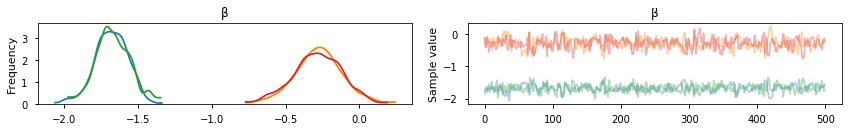

In [4]:
from pymc3 import traceplot

traceplot(trace[500:], varnames=['β']);

## Motivating Example: Coal mining disasters

Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period.

Let's build a model for this series and attempt to estimate when the change occurred.

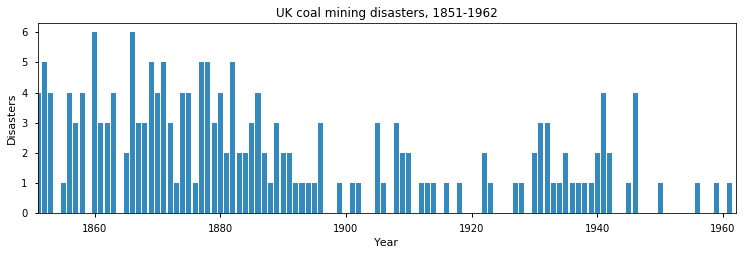

In [5]:
import numpy as np
import matplotlib.pyplot as plt

disasters_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                         3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                         2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                         1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                         0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                         3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

n_years = len(disasters_data)

plt.figure(figsize=(12.5, 3.5))
plt.bar(np.arange(1851, 1962), disasters_data, color="#348ABD")
plt.xlabel("Year")
plt.ylabel("Disasters")
plt.title("UK coal mining disasters, 1851-1962")
plt.xlim(1851, 1962);

We represent our conceptual model formally as a statistical model:

$$\begin{array}{ccc}  
(y_t | \tau, \lambda_1, \lambda_2) \sim\text{Poisson}\left(r_t\right), & r_t=\left\{
\begin{array}{lll}             
\lambda_1 &\text{if}& t< \tau\\ 
\lambda_2 &\text{if}& t\ge \tau             
\end{array}\right.,&t\in[t_l,t_h]\\         
\tau \sim \text{DiscreteUniform}(t_l, t_h)\\         
\lambda_1\sim \text{Exponential}(a)\\         
\lambda_2\sim \text{Exponential}(b)     
\end{array}$$

Because we have defined $y$ by its dependence on $\tau$, $\lambda_1$ and $\lambda_2$, the latter three are known as the *parents* of $y$, and $y$ is called their *child*. Similarly, the parents of $\tau$ are $t_l$ and $t_h$, and $\tau$ is the child of $t_l$ and $t_h$.

## Implementing a PyMC Model

At the model-specification stage (before the data are observed), $y$, $\tau$, $\lambda_1$, and $\lambda_2$ are all random variables. Bayesian "random" variables have not necessarily arisen from a physical random process. The Bayesian interpretation of probability is **epistemic**, meaning random variable $x$'s probability distribution $p(x)$ represents our knowledge and uncertainty about $x$'s value. Candidate values of $x$ for which $p(x)$ is high are relatively more probable, given what we know. 

We can generally divide the variables in a Bayesian model into two types: **stochastic** and **deterministic**. The only deterministic variable in this model is $r$. If we knew the values of $r$'s parents, we could compute the value of $r$ exactly. A deterministic like $r$ is defined by a mathematical function that returns its value given values for its parents. Deterministic variables are sometimes called the *systemic* part of the model. The nomenclature is a bit confusing, because these objects usually represent random variables; since the parents of $r$ are random, $r$ is random also.

On the other hand, even if the values of the parents of variables `switchpoint`, `disasters` (before observing the data), `early_mean` or `late_mean` were known, we would still be uncertain of their values. These variables are stochastic, characterized by probability distributions that express how plausible their candidate values are, given values for their parents.

Let's begin by defining the unknown switchpoint as a discrete uniform random variable:

In [6]:
from pymc3 import DiscreteUniform

with Model() as disaster_model:

    switchpoint = DiscreteUniform('switchpoint', lower=0, upper=n_years)

We have done two things here. First, we have created a `Model` object; a `Model` is a Python object that encapsulates all of the variables that comprise our theoretical model, keeping them in a single container so that they may be used as a unit. After a `Model` is created, we can populate it with all of the model components that we specified when we wrote the model down. 

Notice that the `Model` above was declared using a `with` statement. This expression is used to define a Python idiom known as a **context manager**. Context managers, in general, are used to manage resources of some kind within a program. In this case, our resource is a `Model`, and we would like to add variables to it so that we can fit our statistical model. The key characteristic of the context manager is that the resources it manages are only defined within the indented block corresponding to the `with` statement. PyMC uses this idiom to automatically add defined variables to a model. Thus, any variable we define is automatically added to the `Model`, without having to explicitly add it. This avoids the repetitive syntax of `add` methods/functions that you see in some machine learning packages:

```python
model.add(a_variable)
model.add(another_variable)
model.add(yet_another_variable)
model.add(and_again)
model.add(please_kill_me_now)
...
```

In fact, PyMC variables cannot be defined without a corresponding `Model`:

In [7]:
oops = DiscreteUniform('oops', lower=0, upper=10)

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

However, variables can be explicitly added to models without the use of a context manager, via the variable's optional `model` argument.

```python
disaster_model = Model()
switchpoint = DiscreteUniform('switchpoint', lower=0, upper=110, model=disaster_model)
```

Or, if we just want a discrete uniform distribution, and do not need to use it in a PyMC3 model necessarily, we can create one using the `dist` classmethod.

In [8]:
x = DiscreteUniform.dist(lower=0, upper=100)
x

`DiscreteUniform` is an object that represents uniformly-distributed discrete variables. Use of this distribution
suggests that we have no preference *a priori* regarding the location of the switchpoint; all values are equally likely. 

PyMC3 includes most of the common random variable **distributions** used for statistical modeling.

In [9]:
from pymc3 import distributions
distributions.__all__

['Uniform',
 'Flat',
 'HalfFlat',
 'Normal',
 'Beta',
 'Kumaraswamy',
 'Exponential',
 'Laplace',
 'StudentT',
 'Cauchy',
 'HalfCauchy',
 'Gamma',
 'Weibull',
 'Bound',
 'Lognormal',
 'HalfStudentT',
 'ChiSquared',
 'HalfNormal',
 'Wald',
 'Pareto',
 'InverseGamma',
 'ExGaussian',
 'VonMises',
 'Binomial',
 'BetaBinomial',
 'Bernoulli',
 'Poisson',
 'NegativeBinomial',
 'ConstantDist',
 'Constant',
 'ZeroInflatedPoisson',
 'ZeroInflatedNegativeBinomial',
 'ZeroInflatedBinomial',
 'DiscreteUniform',
 'Geometric',
 'Categorical',
 'OrderedLogistic',
 'DensityDist',
 'Distribution',
 'Continuous',
 'Discrete',
 'NoDistribution',
 'TensorType',
 'MvNormal',
 'MatrixNormal',
 'KroneckerNormal',
 'MvStudentT',
 'Dirichlet',
 'Multinomial',
 'Wishart',
 'WishartBartlett',
 'LKJCholeskyCov',
 'LKJCorr',
 'AR1',
 'AR',
 'GaussianRandomWalk',
 'MvGaussianRandomWalk',
 'MvStudentTRandomWalk',
 'GARCH11',
 'SkewNormal',
 'Mixture',
 'NormalMixture',
 'Triangular',
 'DiscreteWeibull',
 'Gumbel',
 '

By having a library of variables that represent statistical distributions, users are relieved of having to code distrbutions themselves. 

Similarly, we can create the exponentially-distributed variables `early_mean` and `late_mean` for the early and late Poisson rates, respectively (also in the context of the model `distater_model`):

In [10]:
from pymc3 import Exponential

with disaster_model:
    
    early_mean = Exponential('early_mean', 1)
    late_mean = Exponential('late_mean', 1)

Next, we define the variable `rate`, which selects the early rate `early_mean` for times before `switchpoint` and the late rate `late_mean` for times after `switchpoint`. We create `rate` using the `switch` function, which returns `early_mean` when the switchpoint is larger than (or equal to) a particular year, and `late_mean` otherwise.

In [11]:
from pymc3.math import switch

with disaster_model:
    
    rate = switch(switchpoint >= np.arange(n_years), early_mean, late_mean)

The last step is to define the **data likelihood**, or sampling distribution. In this case, our measured outcome is the number of disasters in each year, `disasters`. This is a stochastic variable but unlike `early_mean` and `late_mean` we have *observed* its value. To express this, we set the argument `observed` to the observed sequence of disasters. This tells PyMC that this distribution's value is fixed, and should not be changed:

In [12]:
from pymc3 import Poisson

with disaster_model:
    
    disasters = Poisson('disasters', mu=rate, observed=disasters_data)

> ### Why are data and unknown variables represented by the same object?

>Since its represented by PyMC random variable object, `disasters` is defined by its dependence on its parent `rate` even though its value is **fixed**. This isn't just a quirk of PyMC's syntax; Bayesian hierarchical notation itself makes no distinction between random variables and data. The reason is simple: to use Bayes' theorem to compute the posterior, we require the likelihood. Even though `disasters`'s value is known and fixed, we need to formally assign it a *probability distribution* as if it were a random variable. Remember, the likelihood and the probability function are essentially the same, except that the former is regarded as a function of the parameters and the latter as a function of the data. This point can be counterintuitive at first, as many peoples' instinct is to regard data as fixed a priori and unknown variables as dependent on the data. 

> One way to understand this is to think of statistical models as predictive models for data, or as models of the processes that gave rise to data. Before observing the value of `disasters`, we could have sampled from its prior predictive distribution $p(y)$ (*i.e.* the marginal distribution of the data) as follows:

> -   Sample `early_mean`, `switchpoint` and `late_mean` from their
>     priors.
> -   Sample `disasters` conditional on these values.

> Even after we observe the value of `disasters`, we need to use this process model to make inferences about `early_mean` , `switchpoint` and `late_mean` because its the only information we have about how the variables are related.

> We will see later that we can sample from this fixed stochastic random variable, to obtain predictions after having observed our data.

The model that we specified at the top of the page has now been fully implemented in PyMC3. Let's have a look at the model's attributes to see what we have.

The stochastic nodes in the model are identified in the `vars` (*i.e.* variables) attribute:

In [13]:
disaster_model.vars

[switchpoint, early_mean_log__, late_mean_log__]

The last two variables are the log-transformed versions of the early and late rate parameters. In PyMC3, variables with purely positive priors like `Exponential` are **transformed** with a log function. This makes sampling more robust. Behind the scenes, a variable in the unconstrained space (named `<variable name>_log_`) is added to the model for sampling. In this model this happens behind the scenes. Variables with priors that constrain them on two sides, like `Beta` or `Uniform` (continuous), are also transformed to be unconstrained but with a log odds transform.

The original variables have become deterministic nodes in the model, since they only represent values that have been back-transformed from the transformed variable, which has been subject to fitting or sampling.

In [14]:
disaster_model.deterministics

[early_mean, late_mean]

You might wonder why `rate`, which is a deterministic component of the model, is not in this list. This is because, unlike the other components of the model, `rate` has not been given a name and given a formal PyMC data structure. It is essentially an **intermediate calculation** in the model, implying that we are not interested in its value when it comes to summarizing the output from the model. Most PyMC objects have a name assigned; these names are used for storage and post-processing:

-   as keys in on-disk databases,
-   as axis labels in plots of traces,
-   as table labels in summary statistics.

If we wish to include `rate` in our output, we need to make it a `Deterministic` object, and give it a name:

In [15]:
from pymc3 import Deterministic

with disaster_model:
    
    rate = Deterministic('rate', switch(switchpoint >= np.arange(n_years), early_mean, late_mean))

Now, `rate` is included in the `Model`'s deterministics list, and the model will retain its samples during MCMC sampling, for example.

In [16]:
disaster_model.deterministics

[early_mean, late_mean, rate]

## PyMC3 Variables

Each of the built-in statistical variables are subclasses of the generic `Distribution` class in PyMC3. The `Distribution` carries relevant **attributes** about the probability distribution, such as the data type (called `dtype`), any relevant transformations (`transform`, see below), and initial values (`init_value`).

In [17]:
disasters.dtype

'int64'

In [18]:
early_mean.init_value

array(0.69314718)

PyMC's built-in distribution variables can also be used to generate **random values** from that variable. For example, the `switchpoint`, which is a discrete uniform random variable, can generate random draws:

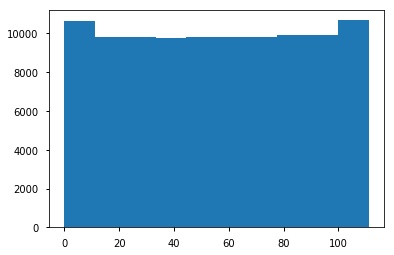

In [19]:
plt.hist(switchpoint.random(size=100000));

As we noted earlier, some variables have undergone **transformations** prior to sampling. Such variables will have `transformed` attributes that points to the variable that it has been transformed to.

In [20]:
early_mean.transformed

early_mean_log__

Variables will usually have an associated distribution, as determined by the constructor used to create it. For example, the `switchpoint` variable was created by calling `DiscreteUniform()`. Hence, its distribution is `DiscreteUniform`:

In [21]:
switchpoint.distribution

As with all Python objects, the underlying type of a variable can be exposed with the `type()` function:

In [22]:
type(switchpoint)

pymc3.model.FreeRV

In [23]:
type(disasters)

pymc3.model.ObservedRV

We will learn more about these types in an upcoming section.

## Variable log-probabilities

All PyMC3 stochastic variables can evaluate their probability mass or density functions at a particular value, given the values of their parents. The **logarithm** of a stochastic object's probability mass or density can be
accessed via the `logp` method. 

In [24]:
switchpoint.logp({'switchpoint':15, 'early_mean_log__':1, 'late_mean_log__':1})

array(-4.71849887)

For **vector-valued** variables like `disasters`, the `logp` attribute returns the **sum** of the logarithms of
the joint probability or density of all elements of the value.

In [25]:
disasters.logp({'switchpoint':55, 'early_mean_log__':1, 'late_mean_log__':1})

array(-225.5380749)

### Custom variables

Though we created the variables in `disaster_model` using well-known probability distributions that are available in PyMC3, its possible to create custom distributions by **wrapping** functions that compute an arbitrary log-probability using the `DensityDist` function. For example, our initial example showed an exponential survival function, which accounts for censored data. If we pass this function as the `logp` argument for `DensityDist`, we can use it as the data likelihood in a survival model:

```python
def logp(failure, value):
    return (failure * log(lam) - lam * value).sum()

x = DensityDist('x', logp, observed={'failure':failure, 'value':t})
```

Users are thus not
limited to the set of of statistical distributions provided by PyMC.

## Fitting the model with MCMC

PyMC3's `sample` function will fit probability models (linked collections of variables) like ours using Markov chain Monte Carlo (MCMC) sampling. Unless we manually assign particular algorithms to variables in our model, PyMC will assign algorithms that it deems appropriate (it usually does a decent job of this):

In [26]:
with disaster_model:
    trace = sample(2000, init=None)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_mean, early_mean]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 2051.74draws/s]
The number of effective samples is smaller than 10% for some parameters.


This returns the Markov chain of draws from the model in a data structure called a **trace**.

In [27]:
trace

<MultiTrace: 2 chains, 2000 iterations, 6 variables>

The `sample()` function always takes at least one argument, `draws`, which specifies how many samples to draw. However, there are a number of additional optional arguments that are worth knowing about:

In [28]:
help(sample)

Help on function sample in module pymc3.sampling:

sample(draws=500, step=None, init='auto', n_init=200000, start=None, trace=None, chain_idx=0, chains=None, cores=None, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=None, random_seed=None, live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, use_mmap=False, **kwargs)
    Draw samples from the posterior using the given step methods.
    
    Multiple step methods are supported via compound step methods.
    
    Parameters
    ----------
    draws : int
        The number of samples to draw. Defaults to 500. The number of tuned samples are discarded
        by default. See discard_tuned_samples.
    step : function or iterable of functions
        A step function or collection of functions. If there are variables without a step methods,
        step methods for those variables will be assigned automatically.
    init : str
        Initialization method to use for au

The `step` argument is what allows users to manually override the sampling algorithms used to fit the model. For example, if we wanted to use a **slice sampler** to sample the `early_mean` and `late_mean` variables, we could specify it:

In [29]:
from pymc3 import Slice

with disaster_model:
    step_trace = sample(1000, step=Slice(vars=[early_mean, late_mean]))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Slice: [late_mean]
>>Slice: [early_mean]
>Metropolis: [switchpoint]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1925.51draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


### Accessing the samples

The output of the `sample` function is a `MultiTrace` object, which stores the sequence of samples for each variable in the model. These traces can be accessed using dict-style indexing:


In [30]:
trace['late_mean']

array([1.14558806, 1.14558806, 0.7046883 , ..., 1.10135344, 1.05198641,
       0.88392784])

The trace can also be sliced using the NumPy array slice `[start:stop:step]`. 

In [31]:
trace['late_mean', -5:]

array([0.91175737, 0.88773046, 1.04465321, 0.74598613, 0.73650116,
       0.84567756, 0.93130468, 1.10135344, 1.05198641, 0.88392784])

In [32]:
trace['late_mean', ::10]

array([1.14558806, 1.13613059, 1.04234709, 0.90777608, 1.01107933,
       0.94064051, 1.00065726, 0.97276203, 0.97078441, 0.90778549,
       1.0070804 , 0.77409924, 1.07490111, 0.99365468, 0.74937172,
       0.96023752, 0.92433897, 0.83224932, 1.00835732, 0.84541289,
       0.84622169, 0.82885796, 0.98153712, 0.87088264, 1.02101414,
       1.02465447, 0.8301194 , 0.92658701, 0.86211679, 1.14734418,
       0.85703201, 1.02818423, 1.02822672, 0.88633363, 0.97282179,
       1.12528003, 0.82328619, 0.92683528, 0.91980381, 0.84366238,
       0.88351416, 0.98487344, 0.97339188, 0.9321541 , 0.75574034,
       0.89306407, 0.86548888, 1.01867225, 0.89092728, 0.74514905,
       1.03391218, 1.08926257, 0.76927009, 1.06288935, 0.95096326,
       1.14325403, 0.8562135 , 1.14079244, 0.98954392, 1.06509298,
       0.88693543, 1.19641385, 0.89305512, 0.95544916, 1.06555716,
       1.17262758, 1.00492167, 0.86498207, 0.88520392, 0.97671489,
       1.02180648, 0.90288655, 0.67556109, 0.96850953, 0.77160

### Sampling output

You can examine the marginal posterior of any variable by plotting a
histogram of its trace:

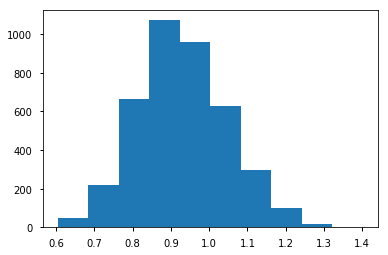

In [33]:
plt.hist(trace['late_mean']);

PyMC has its own plotting functionality dedicated to plotting MCMC output. For example, we can obtain a time series plot of the trace and a histogram using `traceplot`:

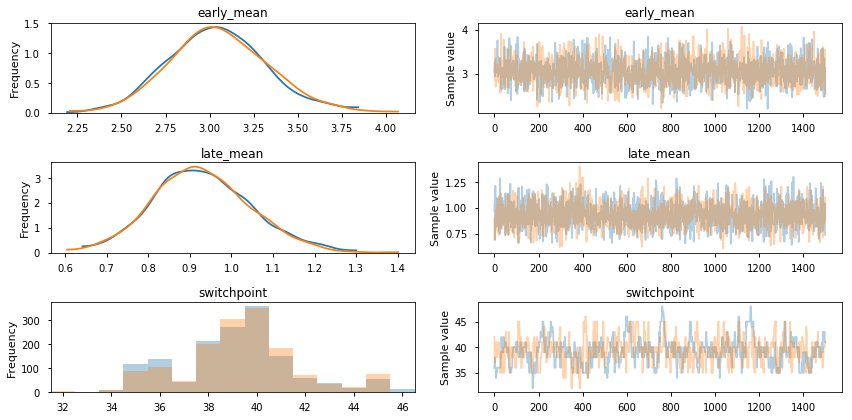

In [34]:
from pymc3 import traceplot

traceplot(trace[500:], varnames=['early_mean', 'late_mean', 'switchpoint']);

The upper left-hand pane of each figure shows the temporal series of the
samples from each parameter, while below is an autocorrelation plot of
the samples. The right-hand pane shows a histogram of the trace. The
trace is useful for evaluating and diagnosing the algorithm's
performance, while the histogram is useful for
visualizing the posterior.

For a non-graphical summary of the posterior, simply call the `stats` method.

In [35]:
from pymc3 import summary

summary(trace[500:], varnames=['early_mean', 'late_mean'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
early_mean,3.050744,0.279923,0.007263,2.515853,3.627701,1473.048351,1.000716
late_mean,0.930112,0.115923,0.002505,0.706456,1.167284,2038.297728,1.000014


## References

1. Salvatier, J., Wiecki, T. V., & Fonnesbeck, C. (2016). Probabilistic programming in Python using PyMC3. PeerJ Computer Science, 2(2), e55. http://doi.org/10.7717/peerj-cs.55